In [16]:
from Bio import SeqIO
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np

r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;

# define universe of possible input values
alphabet = 'OARNDCQEGHILKMFPSTWYV'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

i = 0
#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            print(data, i)
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("./Datasets/training_data/H_train.fasta", "fasta"):

    innertest1()
    i += 1
    
#print(len(r_test_x))

#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded) 
    r_test_y.append(negat_0)

for seq_record in SeqIO.parse("./Datasets/training_data/H_train_neg.fasta", "fasta"):
    innertest2()
# Changing to array (matrix)    
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)

# Balancing test dataset
# Testing Data Balancing by undersampling####################################
rus = RandomUnderSampler(random_state=7)
x_res3, y_res3 = rus.fit_resample(r_test_x, r_test_y)
#Shuffling
r_test_x, r_test_y = shuffle(x_res3, y_res3, random_state=7)
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)

#print(r_test_y.shape)
r_test_x = np.expand_dims(r_test_x, 1)
print(r_test_x.shape)

(7170, 1, 25)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DLMal(nn.Module):
    def __init__(self):
        super(DLMal, self).__init__()
        self.embedding = nn.Embedding(25,21)
        self.conv1 = nn.Conv2d(1, 64, (15, 3))
        self.dropout1 = nn.Dropout(0.6)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.dropout2 = nn.Dropout(0.6)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4096, 768)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(768, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.embedding(x)
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = self.dropout2(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        return self.fc3(x)
net = DLMal()
y = net(torch.from_numpy(np.array([r_test_x[0]])))#convert array numpy to tensor
print(y)
print(r_test_y)

tensor([[ 0.0770, -0.0506]], grad_fn=<AddmmBackward>)
[1 0 0 ... 0 0 1]


In [17]:
import torch
from torch.utils.data import Dataset

class MALDataset(Dataset):
    def __init__(self, r_test_x, r_test_y):
        self.r_test_x = r_test_x
        self.r_test_y = r_test_y

    def __len__(self):
        return len(self.r_test_x)

    def __getitem__(self, idx):
        data = torch.from_numpy(np.array(r_test_x[idx]))
        label = [[1,0],[0,1]]
        label = torch.from_numpy(np.array(label[r_test_y[idx]], dtype='float32'))
        return data, label

ratio = 0.7

trainset = MALDataset(r_test_x[:int(len(r_test_x)*ratio)], r_test_y[:int(len(r_test_y)*ratio)])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

valset = MALDataset(r_test_x[int(len(r_test_x)*ratio):], r_test_y[int(len(r_test_y)*ratio):])
valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                          shuffle=True, num_workers=4)
# Define a Loss function and optimizer
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_accs = []
train_losses = []
val_accs = []
val_losses = []


#Train the network
for epoch in range(170):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    train_acc = 0.0
    train_tot_acc = 0
    train_tot_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        outputs = outputs[:,1] > outputs[:,0]
        labels = labels[:,1] > labels[:,0]
        acc = np.sum(outputs.astype("int32") == labels.astype("int32"))/len(labels)
#         print(outputs.astype('int32'), labels.astype("int32"))
        train_acc += acc
        # print statistics
        running_loss += loss.item()
        train_tot_loss += loss.item()
        train_tot_acc += acc
        if i % 1 == 0: 
            print('[%d, %5d] train loss: %.3f train acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1, train_acc/ 1))
            running_loss = 0.0
            train_acc = 0.0
    
    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        outputs = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        outputs = outputs[:,1] > outputs[:,0]
        labels = labels[:,1] > labels[:,0]
        acc = np.sum(outputs.astype("int32") == labels.astype("int32"))/len(labels)
        val_acc += acc
    print('[%d] val loss: %.3f val acc: %.3f' %
              (epoch + 1, val_loss / len(valloader), val_acc/len(valloader)))
    train_accs.append(train_tot_acc/len(trainloader))
    train_losses.append(train_tot_loss/len(trainloader))
    val_accs.append(val_acc / len(valloader))
    val_losses.append(val_loss / len(valloader))

PATH = './Path/dlmal_e_net.pth'
torch.save(net, PATH)

print('Finished Training')

[1,     1] train loss: 0.391 train acc: 0.832
[1,     2] train loss: 0.412 train acc: 0.840
[1,     3] train loss: 0.356 train acc: 0.852
[1,     4] train loss: 0.419 train acc: 0.805
[1,     5] train loss: 0.362 train acc: 0.836
[1,     6] train loss: 0.441 train acc: 0.777
[1,     7] train loss: 0.447 train acc: 0.797
[1,     8] train loss: 0.477 train acc: 0.785
[1,     9] train loss: 0.371 train acc: 0.824
[1,    10] train loss: 0.380 train acc: 0.832
[1,    11] train loss: 0.388 train acc: 0.801
[1,    12] train loss: 0.407 train acc: 0.820
[1,    13] train loss: 0.449 train acc: 0.762
[1,    14] train loss: 0.396 train acc: 0.812
[1,    15] train loss: 0.383 train acc: 0.836
[1,    16] train loss: 0.422 train acc: 0.797
[1,    17] train loss: 0.413 train acc: 0.793
[1,    18] train loss: 0.422 train acc: 0.777
[1,    19] train loss: 0.416 train acc: 0.793
[1,    20] train loss: 0.408 train acc: 0.813
[1] val loss: 0.351 val acc: 0.950
[2,     1] train loss: 0.399 train acc: 0.809

[9,    14] train loss: 0.389 train acc: 0.809
[9,    15] train loss: 0.319 train acc: 0.871
[9,    16] train loss: 0.363 train acc: 0.836
[9,    17] train loss: 0.368 train acc: 0.820
[9,    18] train loss: 0.358 train acc: 0.801
[9,    19] train loss: 0.334 train acc: 0.883
[9,    20] train loss: 0.327 train acc: 0.890
[9] val loss: 0.313 val acc: 0.959
[10,     1] train loss: 0.360 train acc: 0.816
[10,     2] train loss: 0.325 train acc: 0.855
[10,     3] train loss: 0.364 train acc: 0.824
[10,     4] train loss: 0.389 train acc: 0.832
[10,     5] train loss: 0.355 train acc: 0.844
[10,     6] train loss: 0.355 train acc: 0.840
[10,     7] train loss: 0.325 train acc: 0.859
[10,     8] train loss: 0.315 train acc: 0.859
[10,     9] train loss: 0.373 train acc: 0.816
[10,    10] train loss: 0.323 train acc: 0.867
[10,    11] train loss: 0.384 train acc: 0.828
[10,    12] train loss: 0.342 train acc: 0.828
[10,    13] train loss: 0.295 train acc: 0.879
[10,    14] train loss: 0.372 tr

[18,     2] train loss: 0.315 train acc: 0.875
[18,     3] train loss: 0.298 train acc: 0.875
[18,     4] train loss: 0.396 train acc: 0.809
[18,     5] train loss: 0.324 train acc: 0.879
[18,     6] train loss: 0.359 train acc: 0.828
[18,     7] train loss: 0.348 train acc: 0.844
[18,     8] train loss: 0.334 train acc: 0.855
[18,     9] train loss: 0.305 train acc: 0.859
[18,    10] train loss: 0.314 train acc: 0.859
[18,    11] train loss: 0.380 train acc: 0.816
[18,    12] train loss: 0.396 train acc: 0.828
[18,    13] train loss: 0.365 train acc: 0.832
[18,    14] train loss: 0.329 train acc: 0.855
[18,    15] train loss: 0.262 train acc: 0.883
[18,    16] train loss: 0.314 train acc: 0.836
[18,    17] train loss: 0.358 train acc: 0.824
[18,    18] train loss: 0.337 train acc: 0.859
[18,    19] train loss: 0.310 train acc: 0.883
[18,    20] train loss: 0.288 train acc: 0.890
[18] val loss: 0.247 val acc: 0.987
[19,     1] train loss: 0.346 train acc: 0.852
[19,     2] train loss: 

[26,    11] train loss: 0.395 train acc: 0.832
[26,    12] train loss: 0.278 train acc: 0.891
[26,    13] train loss: 0.360 train acc: 0.820
[26,    14] train loss: 0.345 train acc: 0.840
[26,    15] train loss: 0.294 train acc: 0.867
[26,    16] train loss: 0.323 train acc: 0.828
[26,    17] train loss: 0.253 train acc: 0.898
[26,    18] train loss: 0.304 train acc: 0.859
[26,    19] train loss: 0.353 train acc: 0.832
[26,    20] train loss: 0.277 train acc: 0.858
[26] val loss: 0.213 val acc: 0.994
[27,     1] train loss: 0.328 train acc: 0.871
[27,     2] train loss: 0.296 train acc: 0.871
[27,     3] train loss: 0.289 train acc: 0.871
[27,     4] train loss: 0.279 train acc: 0.859
[27,     5] train loss: 0.262 train acc: 0.898
[27,     6] train loss: 0.214 train acc: 0.914
[27,     7] train loss: 0.254 train acc: 0.898
[27,     8] train loss: 0.246 train acc: 0.895
[27,     9] train loss: 0.330 train acc: 0.863
[27,    10] train loss: 0.304 train acc: 0.883
[27,    11] train loss: 

[34,    20] train loss: 0.285 train acc: 0.871
[34] val loss: 0.183 val acc: 0.997
[35,     1] train loss: 0.270 train acc: 0.871
[35,     2] train loss: 0.255 train acc: 0.902
[35,     3] train loss: 0.256 train acc: 0.887
[35,     4] train loss: 0.260 train acc: 0.887
[35,     5] train loss: 0.265 train acc: 0.891
[35,     6] train loss: 0.198 train acc: 0.934
[35,     7] train loss: 0.300 train acc: 0.891
[35,     8] train loss: 0.239 train acc: 0.891
[35,     9] train loss: 0.244 train acc: 0.914
[35,    10] train loss: 0.231 train acc: 0.891
[35,    11] train loss: 0.305 train acc: 0.875
[35,    12] train loss: 0.268 train acc: 0.891
[35,    13] train loss: 0.250 train acc: 0.891
[35,    14] train loss: 0.290 train acc: 0.859
[35,    15] train loss: 0.327 train acc: 0.855
[35,    16] train loss: 0.333 train acc: 0.879
[35,    17] train loss: 0.288 train acc: 0.859
[35,    18] train loss: 0.262 train acc: 0.887
[35,    19] train loss: 0.250 train acc: 0.867
[35,    20] train loss: 

[43,     8] train loss: 0.254 train acc: 0.910
[43,     9] train loss: 0.260 train acc: 0.906
[43,    10] train loss: 0.252 train acc: 0.914
[43,    11] train loss: 0.272 train acc: 0.883
[43,    12] train loss: 0.241 train acc: 0.895
[43,    13] train loss: 0.268 train acc: 0.879
[43,    14] train loss: 0.254 train acc: 0.875
[43,    15] train loss: 0.246 train acc: 0.898
[43,    16] train loss: 0.278 train acc: 0.875
[43,    17] train loss: 0.247 train acc: 0.887
[43,    18] train loss: 0.243 train acc: 0.895
[43,    19] train loss: 0.257 train acc: 0.871
[43,    20] train loss: 0.295 train acc: 0.845
[43] val loss: 0.149 val acc: 0.998
[44,     1] train loss: 0.230 train acc: 0.906
[44,     2] train loss: 0.240 train acc: 0.895
[44,     3] train loss: 0.238 train acc: 0.891
[44,     4] train loss: 0.253 train acc: 0.895
[44,     5] train loss: 0.215 train acc: 0.922
[44,     6] train loss: 0.241 train acc: 0.910
[44,     7] train loss: 0.256 train acc: 0.898
[44,     8] train loss: 

[51,    17] train loss: 0.230 train acc: 0.914
[51,    18] train loss: 0.203 train acc: 0.910
[51,    19] train loss: 0.266 train acc: 0.895
[51,    20] train loss: 0.199 train acc: 0.916
[51] val loss: 0.122 val acc: 0.999
[52,     1] train loss: 0.192 train acc: 0.918
[52,     2] train loss: 0.249 train acc: 0.895
[52,     3] train loss: 0.186 train acc: 0.906
[52,     4] train loss: 0.158 train acc: 0.938
[52,     5] train loss: 0.184 train acc: 0.930
[52,     6] train loss: 0.221 train acc: 0.898
[52,     7] train loss: 0.223 train acc: 0.914
[52,     8] train loss: 0.308 train acc: 0.875
[52,     9] train loss: 0.237 train acc: 0.918
[52,    10] train loss: 0.192 train acc: 0.934
[52,    11] train loss: 0.243 train acc: 0.875
[52,    12] train loss: 0.286 train acc: 0.891
[52,    13] train loss: 0.294 train acc: 0.871
[52,    14] train loss: 0.238 train acc: 0.918
[52,    15] train loss: 0.173 train acc: 0.914
[52,    16] train loss: 0.264 train acc: 0.895
[52,    17] train loss: 

[60,     5] train loss: 0.177 train acc: 0.926
[60,     6] train loss: 0.188 train acc: 0.918
[60,     7] train loss: 0.244 train acc: 0.902
[60,     8] train loss: 0.203 train acc: 0.910
[60,     9] train loss: 0.231 train acc: 0.898
[60,    10] train loss: 0.180 train acc: 0.930
[60,    11] train loss: 0.183 train acc: 0.922
[60,    12] train loss: 0.228 train acc: 0.906
[60,    13] train loss: 0.192 train acc: 0.934
[60,    14] train loss: 0.252 train acc: 0.902
[60,    15] train loss: 0.248 train acc: 0.883
[60,    16] train loss: 0.206 train acc: 0.895
[60,    17] train loss: 0.211 train acc: 0.918
[60,    18] train loss: 0.192 train acc: 0.914
[60,    19] train loss: 0.160 train acc: 0.953
[60,    20] train loss: 0.233 train acc: 0.923
[60] val loss: 0.102 val acc: 0.999
[61,     1] train loss: 0.235 train acc: 0.902
[61,     2] train loss: 0.230 train acc: 0.922
[61,     3] train loss: 0.244 train acc: 0.902
[61,     4] train loss: 0.226 train acc: 0.914
[61,     5] train loss: 

[68,    14] train loss: 0.216 train acc: 0.922
[68,    15] train loss: 0.199 train acc: 0.906
[68,    16] train loss: 0.189 train acc: 0.914
[68,    17] train loss: 0.179 train acc: 0.938
[68,    18] train loss: 0.173 train acc: 0.934
[68,    19] train loss: 0.164 train acc: 0.914
[68,    20] train loss: 0.237 train acc: 0.903
[68] val loss: 0.081 val acc: 1.000
[69,     1] train loss: 0.189 train acc: 0.938
[69,     2] train loss: 0.181 train acc: 0.922
[69,     3] train loss: 0.190 train acc: 0.914
[69,     4] train loss: 0.153 train acc: 0.938
[69,     5] train loss: 0.218 train acc: 0.898
[69,     6] train loss: 0.213 train acc: 0.938
[69,     7] train loss: 0.193 train acc: 0.926
[69,     8] train loss: 0.173 train acc: 0.918
[69,     9] train loss: 0.176 train acc: 0.941
[69,    10] train loss: 0.161 train acc: 0.934
[69,    11] train loss: 0.128 train acc: 0.949
[69,    12] train loss: 0.149 train acc: 0.949
[69,    13] train loss: 0.216 train acc: 0.910
[69,    14] train loss: 

[77,     2] train loss: 0.217 train acc: 0.918
[77,     3] train loss: 0.185 train acc: 0.945
[77,     4] train loss: 0.153 train acc: 0.938
[77,     5] train loss: 0.134 train acc: 0.941
[77,     6] train loss: 0.171 train acc: 0.941
[77,     7] train loss: 0.251 train acc: 0.887
[77,     8] train loss: 0.185 train acc: 0.914
[77,     9] train loss: 0.173 train acc: 0.922
[77,    10] train loss: 0.159 train acc: 0.938
[77,    11] train loss: 0.225 train acc: 0.918
[77,    12] train loss: 0.153 train acc: 0.945
[77,    13] train loss: 0.170 train acc: 0.941
[77,    14] train loss: 0.156 train acc: 0.934
[77,    15] train loss: 0.153 train acc: 0.949
[77,    16] train loss: 0.128 train acc: 0.941
[77,    17] train loss: 0.123 train acc: 0.953
[77,    18] train loss: 0.138 train acc: 0.945
[77,    19] train loss: 0.148 train acc: 0.934
[77,    20] train loss: 0.228 train acc: 0.929
[77] val loss: 0.069 val acc: 1.000
[78,     1] train loss: 0.161 train acc: 0.930
[78,     2] train loss: 

[85,    11] train loss: 0.174 train acc: 0.930
[85,    12] train loss: 0.158 train acc: 0.938
[85,    13] train loss: 0.161 train acc: 0.930
[85,    14] train loss: 0.163 train acc: 0.941
[85,    15] train loss: 0.197 train acc: 0.914
[85,    16] train loss: 0.210 train acc: 0.906
[85,    17] train loss: 0.164 train acc: 0.949
[85,    18] train loss: 0.102 train acc: 0.949
[85,    19] train loss: 0.166 train acc: 0.926
[85,    20] train loss: 0.134 train acc: 0.948
[85] val loss: 0.062 val acc: 1.000
[86,     1] train loss: 0.096 train acc: 0.977
[86,     2] train loss: 0.113 train acc: 0.965
[86,     3] train loss: 0.108 train acc: 0.961
[86,     4] train loss: 0.177 train acc: 0.926
[86,     5] train loss: 0.156 train acc: 0.930
[86,     6] train loss: 0.141 train acc: 0.922
[86,     7] train loss: 0.172 train acc: 0.957
[86,     8] train loss: 0.142 train acc: 0.941
[86,     9] train loss: 0.169 train acc: 0.930
[86,    10] train loss: 0.175 train acc: 0.938
[86,    11] train loss: 

[93,    20] train loss: 0.162 train acc: 0.923
[93] val loss: 0.046 val acc: 1.000
[94,     1] train loss: 0.115 train acc: 0.953
[94,     2] train loss: 0.165 train acc: 0.945
[94,     3] train loss: 0.161 train acc: 0.930
[94,     4] train loss: 0.113 train acc: 0.957
[94,     5] train loss: 0.153 train acc: 0.938
[94,     6] train loss: 0.149 train acc: 0.941
[94,     7] train loss: 0.153 train acc: 0.930
[94,     8] train loss: 0.078 train acc: 0.969
[94,     9] train loss: 0.126 train acc: 0.953
[94,    10] train loss: 0.142 train acc: 0.945
[94,    11] train loss: 0.106 train acc: 0.969
[94,    12] train loss: 0.153 train acc: 0.961
[94,    13] train loss: 0.190 train acc: 0.906
[94,    14] train loss: 0.126 train acc: 0.957
[94,    15] train loss: 0.221 train acc: 0.914
[94,    16] train loss: 0.250 train acc: 0.898
[94,    17] train loss: 0.112 train acc: 0.961
[94,    18] train loss: 0.111 train acc: 0.949
[94,    19] train loss: 0.153 train acc: 0.941
[94,    20] train loss: 

[102,     7] train loss: 0.100 train acc: 0.969
[102,     8] train loss: 0.176 train acc: 0.934
[102,     9] train loss: 0.224 train acc: 0.910
[102,    10] train loss: 0.082 train acc: 0.965
[102,    11] train loss: 0.176 train acc: 0.953
[102,    12] train loss: 0.163 train acc: 0.945
[102,    13] train loss: 0.134 train acc: 0.941
[102,    14] train loss: 0.130 train acc: 0.941
[102,    15] train loss: 0.116 train acc: 0.953
[102,    16] train loss: 0.137 train acc: 0.941
[102,    17] train loss: 0.148 train acc: 0.930
[102,    18] train loss: 0.097 train acc: 0.961
[102,    19] train loss: 0.161 train acc: 0.938
[102,    20] train loss: 0.141 train acc: 0.935
[102] val loss: 0.047 val acc: 1.000
[103,     1] train loss: 0.138 train acc: 0.938
[103,     2] train loss: 0.147 train acc: 0.938
[103,     3] train loss: 0.139 train acc: 0.945
[103,     4] train loss: 0.109 train acc: 0.945
[103,     5] train loss: 0.153 train acc: 0.941
[103,     6] train loss: 0.114 train acc: 0.953
[10

[110,    12] train loss: 0.126 train acc: 0.957
[110,    13] train loss: 0.150 train acc: 0.934
[110,    14] train loss: 0.118 train acc: 0.945
[110,    15] train loss: 0.109 train acc: 0.961
[110,    16] train loss: 0.183 train acc: 0.938
[110,    17] train loss: 0.119 train acc: 0.941
[110,    18] train loss: 0.110 train acc: 0.957
[110,    19] train loss: 0.160 train acc: 0.938
[110,    20] train loss: 0.176 train acc: 0.923
[110] val loss: 0.032 val acc: 1.000
[111,     1] train loss: 0.144 train acc: 0.953
[111,     2] train loss: 0.096 train acc: 0.965
[111,     3] train loss: 0.152 train acc: 0.949
[111,     4] train loss: 0.159 train acc: 0.938
[111,     5] train loss: 0.157 train acc: 0.945
[111,     6] train loss: 0.157 train acc: 0.941
[111,     7] train loss: 0.120 train acc: 0.961
[111,     8] train loss: 0.155 train acc: 0.941
[111,     9] train loss: 0.141 train acc: 0.941
[111,    10] train loss: 0.136 train acc: 0.949
[111,    11] train loss: 0.110 train acc: 0.961
[11

[118,    17] train loss: 0.227 train acc: 0.910
[118,    18] train loss: 0.237 train acc: 0.906
[118,    19] train loss: 0.239 train acc: 0.902
[118,    20] train loss: 0.247 train acc: 0.890
[118] val loss: 0.113 val acc: 1.000
[119,     1] train loss: 0.202 train acc: 0.926
[119,     2] train loss: 0.201 train acc: 0.902
[119,     3] train loss: 0.232 train acc: 0.902
[119,     4] train loss: 0.248 train acc: 0.883
[119,     5] train loss: 0.149 train acc: 0.949
[119,     6] train loss: 0.203 train acc: 0.934
[119,     7] train loss: 0.238 train acc: 0.918
[119,     8] train loss: 0.200 train acc: 0.922
[119,     9] train loss: 0.165 train acc: 0.930
[119,    10] train loss: 0.201 train acc: 0.918
[119,    11] train loss: 0.191 train acc: 0.906
[119,    12] train loss: 0.162 train acc: 0.945
[119,    13] train loss: 0.232 train acc: 0.879
[119,    14] train loss: 0.182 train acc: 0.934
[119,    15] train loss: 0.235 train acc: 0.895
[119,    16] train loss: 0.234 train acc: 0.910
[11

[127,     1] train loss: 0.143 train acc: 0.945
[127,     2] train loss: 0.140 train acc: 0.938
[127,     3] train loss: 0.188 train acc: 0.930
[127,     4] train loss: 0.131 train acc: 0.953
[127,     5] train loss: 0.154 train acc: 0.934
[127,     6] train loss: 0.178 train acc: 0.938
[127,     7] train loss: 0.149 train acc: 0.934
[127,     8] train loss: 0.139 train acc: 0.941
[127,     9] train loss: 0.176 train acc: 0.934
[127,    10] train loss: 0.178 train acc: 0.930
[127,    11] train loss: 0.187 train acc: 0.938
[127,    12] train loss: 0.179 train acc: 0.938
[127,    13] train loss: 0.153 train acc: 0.941
[127,    14] train loss: 0.138 train acc: 0.949
[127,    15] train loss: 0.217 train acc: 0.922
[127,    16] train loss: 0.201 train acc: 0.914
[127,    17] train loss: 0.155 train acc: 0.914
[127,    18] train loss: 0.177 train acc: 0.934
[127,    19] train loss: 0.197 train acc: 0.922
[127,    20] train loss: 0.203 train acc: 0.916
[127] val loss: 0.056 val acc: 1.000
[12

[135,     6] train loss: 0.120 train acc: 0.945
[135,     7] train loss: 0.184 train acc: 0.922
[135,     8] train loss: 0.151 train acc: 0.949
[135,     9] train loss: 0.125 train acc: 0.938
[135,    10] train loss: 0.141 train acc: 0.949
[135,    11] train loss: 0.224 train acc: 0.906
[135,    12] train loss: 0.128 train acc: 0.961
[135,    13] train loss: 0.155 train acc: 0.941
[135,    14] train loss: 0.215 train acc: 0.918
[135,    15] train loss: 0.176 train acc: 0.934
[135,    16] train loss: 0.151 train acc: 0.930
[135,    17] train loss: 0.163 train acc: 0.934
[135,    18] train loss: 0.165 train acc: 0.941
[135,    19] train loss: 0.112 train acc: 0.957
[135,    20] train loss: 0.128 train acc: 0.935
[135] val loss: 0.056 val acc: 1.000
[136,     1] train loss: 0.116 train acc: 0.945
[136,     2] train loss: 0.128 train acc: 0.941
[136,     3] train loss: 0.211 train acc: 0.918
[136,     4] train loss: 0.137 train acc: 0.945
[136,     5] train loss: 0.151 train acc: 0.945
[13

[143,    11] train loss: 0.141 train acc: 0.945
[143,    12] train loss: 0.112 train acc: 0.965
[143,    13] train loss: 0.144 train acc: 0.949
[143,    14] train loss: 0.141 train acc: 0.945
[143,    15] train loss: 0.154 train acc: 0.949
[143,    16] train loss: 0.130 train acc: 0.957
[143,    17] train loss: 0.216 train acc: 0.918
[143,    18] train loss: 0.118 train acc: 0.953
[143,    19] train loss: 0.148 train acc: 0.949
[143,    20] train loss: 0.075 train acc: 0.981
[143] val loss: 0.042 val acc: 1.000
[144,     1] train loss: 0.146 train acc: 0.938
[144,     2] train loss: 0.143 train acc: 0.941
[144,     3] train loss: 0.082 train acc: 0.965
[144,     4] train loss: 0.147 train acc: 0.926
[144,     5] train loss: 0.162 train acc: 0.941
[144,     6] train loss: 0.149 train acc: 0.961
[144,     7] train loss: 0.145 train acc: 0.945
[144,     8] train loss: 0.162 train acc: 0.945
[144,     9] train loss: 0.122 train acc: 0.949
[144,    10] train loss: 0.120 train acc: 0.957
[14

[151,    16] train loss: 0.119 train acc: 0.953
[151,    17] train loss: 0.135 train acc: 0.941
[151,    18] train loss: 0.197 train acc: 0.926
[151,    19] train loss: 0.142 train acc: 0.938
[151,    20] train loss: 0.112 train acc: 0.974
[151] val loss: 0.036 val acc: 1.000
[152,     1] train loss: 0.125 train acc: 0.953
[152,     2] train loss: 0.084 train acc: 0.973
[152,     3] train loss: 0.184 train acc: 0.918
[152,     4] train loss: 0.087 train acc: 0.969
[152,     5] train loss: 0.116 train acc: 0.961
[152,     6] train loss: 0.104 train acc: 0.961
[152,     7] train loss: 0.103 train acc: 0.961
[152,     8] train loss: 0.094 train acc: 0.953
[152,     9] train loss: 0.120 train acc: 0.961
[152,    10] train loss: 0.144 train acc: 0.926
[152,    11] train loss: 0.093 train acc: 0.969
[152,    12] train loss: 0.129 train acc: 0.938
[152,    13] train loss: 0.151 train acc: 0.953
[152,    14] train loss: 0.081 train acc: 0.980
[152,    15] train loss: 0.110 train acc: 0.953
[15

[159] val loss: 0.031 val acc: 1.000
[160,     1] train loss: 0.136 train acc: 0.949
[160,     2] train loss: 0.098 train acc: 0.949
[160,     3] train loss: 0.100 train acc: 0.949
[160,     4] train loss: 0.093 train acc: 0.969
[160,     5] train loss: 0.088 train acc: 0.980
[160,     6] train loss: 0.148 train acc: 0.945
[160,     7] train loss: 0.112 train acc: 0.949
[160,     8] train loss: 0.121 train acc: 0.957
[160,     9] train loss: 0.079 train acc: 0.961
[160,    10] train loss: 0.147 train acc: 0.949
[160,    11] train loss: 0.140 train acc: 0.930
[160,    12] train loss: 0.071 train acc: 0.965
[160,    13] train loss: 0.157 train acc: 0.949
[160,    14] train loss: 0.114 train acc: 0.961
[160,    15] train loss: 0.099 train acc: 0.957
[160,    16] train loss: 0.078 train acc: 0.973
[160,    17] train loss: 0.092 train acc: 0.965
[160,    18] train loss: 0.081 train acc: 0.969
[160,    19] train loss: 0.150 train acc: 0.949
[160,    20] train loss: 0.133 train acc: 0.948
[16

[168,     5] train loss: 0.135 train acc: 0.961
[168,     6] train loss: 0.101 train acc: 0.961
[168,     7] train loss: 0.094 train acc: 0.961
[168,     8] train loss: 0.106 train acc: 0.953
[168,     9] train loss: 0.107 train acc: 0.965
[168,    10] train loss: 0.139 train acc: 0.941
[168,    11] train loss: 0.186 train acc: 0.922
[168,    12] train loss: 0.117 train acc: 0.953
[168,    13] train loss: 0.128 train acc: 0.945
[168,    14] train loss: 0.113 train acc: 0.961
[168,    15] train loss: 0.117 train acc: 0.949
[168,    16] train loss: 0.072 train acc: 0.977
[168,    17] train loss: 0.092 train acc: 0.961
[168,    18] train loss: 0.081 train acc: 0.969
[168,    19] train loss: 0.168 train acc: 0.934
[168,    20] train loss: 0.093 train acc: 0.968
[168] val loss: 0.023 val acc: 1.000
[169,     1] train loss: 0.078 train acc: 0.973
[169,     2] train loss: 0.110 train acc: 0.949
[169,     3] train loss: 0.134 train acc: 0.945
[169,     4] train loss: 0.072 train acc: 0.973
[16

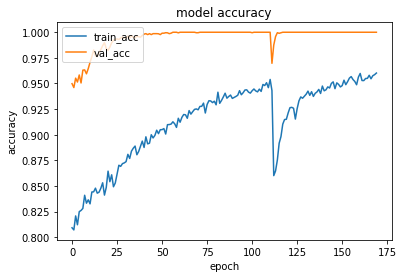

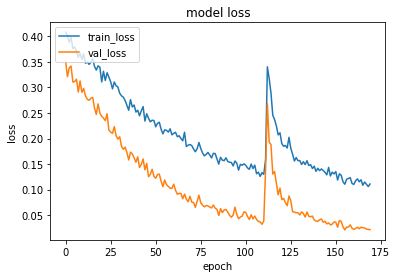

In [18]:
from matplotlib import pyplot as plt

plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [19]:
r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;

# define universe of possible input values
alphabet = 'OARNDCQEGHILKMFPSTWYV'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

i = 0
#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("./Datasets/independent_data/H_test.fasta", "fasta"):
    innertest1()
    i += 1


#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
#             print(data, i)
            return
    integer_encoded = [char_to_int[char] for char in data]
    if integer_encoded[0] == 6: print(data, int_to_char[6], len(r_test_x))
    r_test_x.append(integer_encoded) 
    r_test_y.append(negat_0)
for seq_record in SeqIO.parse("./Datasets/independent_data/H_test_neg.fasta", "fasta"):
    innertest2()
# Changing to array (matrix)    
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)

# Balancing test dataset
# Testing Data Balancing by undersampling####################################
# rus = RandomUnderSampler(random_state=7)
# x_res3, y_res3 = rus.fit_resample(r_test_x, r_test_y)
# #Shuffling
# r_test_x, r_test_y = shuffle(x_res3, y_res3, random_state=7)
# r_test_x = np.array(r_test_x)
# r_test_y = np.array(r_test_y)

r_test_x = np.expand_dims(r_test_x, 1)
print(r_test_x.shape)
print(r_test_x)

HITACLFGGIIEKGLVTYMALGLAL
LQSVNQLLLTATKERIDFLPHYDTL
QPLLLSEDEEDTKRVVRSAKDKRFE
QPLLLSEDEEDTKRVVRSAKDKRFE Q 302
INTKFFQEENTEKLKLKYYNLMIQL
SATVDQRLPECAKLAKEGRLQEVIE
QVRVLELENELQKERQKLGELRKKH
QVRVLELENELQKERQKLGELRKKH Q 305
VYEWARDHRAHHKFSETHADPHNSR
AEKFPSPHPSPAKLKATAGHOOOOO
GGDGLDPAAMEGKDEPLEFKRVLDN
KLYSILQGDSPTKWRTEDFRMFKNG
SSSGRRVKSPSPKSERSERSERSHK
MESLEQRAIDLYKQLKHRPSDHSYS
LIYITLYISECLKKLQKCNSKSQGE
ETLYVYELLGVPKPKESTTGLLKAR
NLPHTPRYYDILKKRLQLPVWEYKD
SVVGTDALKKTKKDDEKSKKSKEEY
TNWNKRDFNQFIKANEKWGRDDIEN
IRQDIEDSVSRMKPWQSEYGGVVFG
AKKGKDEWFSRGKKPIEDPANDTVD
SKTIRKEVGRFEKERVKDFKTVIIK
KATVKAMQEALAKLKEEEERQKREE
DIGKPIEKGPRAKOOOOOOOOOOOO
KLRENKEFLEFRKARSDMLLSRKNQ
QPVRKVQSATHFKKVRGPSRADPNH
QPVRKVQSATHFKKVRGPSRADPNH Q 323
FPSIGSGRNGFPKQTAAQLILKAIS
SGTKAEVSIQNNKDGTYAVTYVPLT
QPQHNGESNEDSKDNHEASTKKKPS
QPQHNGESNEDSKDNHEASTKKKPS Q 326
LVEQTLSDLEQSKCISIEDEMDVAP
DMDYSRIIERLLKLAVPNHLIWLIF
ARREKELEARVRKPAEAERYKLERL
DWIENHGEAFLSKHTGVGKSLHRAR
LLDMSVSFHTHVKELWTWLEELQKE
NTSTAEEELCRLKLLAKHPCHIKKF
ENLERQQKQQVEKM

In [20]:
PATH = './Path/dlmal_h_net.pth'
net = torch.load(PATH, map_location="cpu")
net.eval()

print(r_test_x[0])
print([int_to_char[i] for i in r_test_x[0][0]])
y = net(torch.from_numpy(np.array([r_test_x[0]])))
print(F.softmax(y, dim=1))

print(r_test_x[-1])
print([int_to_char[i] for i in r_test_x[-1][0]])
y = net(torch.from_numpy(np.array([r_test_x[-1]])))
print(F.softmax(y, dim=1))

TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(r_test_x)):
    y = net(torch.from_numpy(np.array([r_test_x[i]])))
    y = F.softmax(y, dim=1)
    y = y.detach().cpu().numpy()
    if (y[0][0] > y[0][1] and r_test_y[i] == 0):
        TN += 1
    elif (y[0][0] < y[0][1] and r_test_y[i] == 1):
        TP += 1
    elif r_test_y[i] == 0:
        FN += 1
        print([int_to_char[i] for i in r_test_x[i][0]], y)
    else:
        FP +=1
        print([int_to_char[i] for i in r_test_x[i][0]], y)
       
print("acc:", (TP+TN)/(TP+TN+FP+FN)*100)
print("sn:", (TP)/(TP+FN)*100)
print("sp:", TN/(TN+FP)*100)
print("mcc:", (TP*TN-FP*FN)/((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**(1/2))

[[ 5  2 15 18  1 16  2  1  1  1  2 15 12 15 16  1 16  7 20 11 17  2  9 11
  11]]
['C', 'R', 'P', 'W', 'A', 'S', 'R', 'A', 'A', 'A', 'R', 'P', 'K', 'P', 'S', 'A', 'S', 'E', 'V', 'L', 'T', 'R', 'H', 'L', 'L']
tensor([[0.6445, 0.3555]], grad_fn=<SoftmaxBackward>)
[[10 14 17 20  6 13  4  4 19 11  8  8 12 15 20  6  3  2  7 11  6  8 19  7
  16]]
['I', 'F', 'T', 'V', 'Q', 'M', 'D', 'D', 'Y', 'L', 'G', 'G', 'K', 'P', 'V', 'Q', 'N', 'R', 'E', 'L', 'Q', 'G', 'Y', 'E', 'S']
tensor([[0.7703, 0.2297]], grad_fn=<SoftmaxBackward>)
['C', 'R', 'P', 'W', 'A', 'S', 'R', 'A', 'A', 'A', 'R', 'P', 'K', 'P', 'S', 'A', 'S', 'E', 'V', 'L', 'T', 'R', 'H', 'L', 'L'] [[0.6445085  0.35549146]]
['L', 'G', 'S', 'I', 'L', 'K', 'T', 'N', 'V', 'R', 'A', 'C', 'K', 'A', 'V', 'G', 'H', 'P', 'F', 'V', 'I', 'Q', 'L', 'G', 'R'] [[0.504349   0.49565095]]
['S', 'S', 'Y', 'N', 'L', 'V', 'P', 'R', 'Y', 'I', 'P', 'Q', 'K', 'Q', 'S', 'E', 'D', 'M', 'H', 'A', 'F', 'V', 'T', 'E', 'V'] [[0.6211862  0.37881377]]
['A', 'Q', 'L', 'A', '

['I', 'R', 'L', 'N', 'L', 'G', 'K', 'K', 'R', 'K', 'M', 'V', 'K', 'V', 'Y', 'T', 'K', 'T', 'D', 'G', 'L', 'V', 'A', 'V', 'H'] [[0.54336005 0.4566399 ]]
['P', 'V', 'E', 'P', 'V', 'L', 'T', 'V', 'H', 'P', 'E', 'S', 'K', 'S', 'K', 'T', 'K', 'T', 'R', 'S', 'R', 'S', 'R', 'G', 'R'] [[0.7803018 0.2196982]]
['S', 'D', 'V', 'R', 'N', 'T', 'V', 'T', 'Y', 'T', 'S', 'L', 'K', 'T', 'K', 'L', 'S', 'N', 'V', 'I', 'N', 'S', 'A', 'T', 'D'] [[0.54414135 0.45585868]]
['T', 'R', 'E', 'L', 'S', 'N', 'F', 'Y', 'F', 'S', 'I', 'I', 'K', 'D', 'R', 'L', 'Y', 'C', 'E', 'K', 'E', 'N', 'D', 'P', 'K'] [[0.6471319  0.35286805]]
['O', 'M', 'K', 'H', 'Y', 'E', 'V', 'E', 'I', 'L', 'D', 'A', 'K', 'T', 'R', 'E', 'K', 'L', 'C', 'F', 'L', 'D', 'K', 'V', 'E'] [[0.56747764 0.4325223 ]]
['Y', 'V', 'K', 'G', 'W', 'I', 'P', 'G', 'N', 'E', 'E', 'N', 'K', 'Q', 'K', 'T', 'D', 'V', 'H', 'Y', 'R', 'S', 'L', 'D', 'G'] [[0.67633647 0.3236635 ]]
['W', 'K', 'E', 'A', 'K', 'P', 'D', 'E', 'L', 'M', 'D', 'S', 'K', 'L', 'R', 'C', 'V', 'F',

['E', 'G', 'T', 'V', 'K', 'A', 'Y', 'V', 'W', 'D', 'N', 'N', 'K', 'D', 'L', 'A', 'E', 'W', 'L', 'E', 'K', 'Q', 'L', 'T', 'E'] [[0.39408723 0.6059128 ]]
['K', 'L', 'E', 'K', 'L', 'D', 'T', 'D', 'L', 'K', 'N', 'Y', 'K', 'G', 'N', 'S', 'I', 'K', 'E', 'S', 'I', 'R', 'R', 'G', 'H'] [[0.48107937 0.51892066]]
['A', 'A', 'V', 'F', 'R', 'S', 'M', 'N', 'S', 'A', 'L', 'G', 'K', 'S', 'P', 'W', 'L', 'A', 'G', 'N', 'E', 'L', 'T', 'V', 'A'] [[0.4862997 0.5137003]]
['R', 'K', 'F', 'F', 'G', 'D', 'K', 'T', 'I', 'V', 'P', 'W', 'K', 'V', 'F', 'R', 'Q', 'C', 'L', 'H', 'E', 'V', 'H', 'Q', 'I'] [[0.2619514 0.7380487]]
['G', 'S', 'V', 'K', 'S', 'F', 'S', 'L', 'G', 'P', 'L', 'R', 'K', 'A', 'V', 'T', 'L', 'N', 'P', 'D', 'N', 'S', 'Y', 'I', 'K'] [[0.46246025 0.5375398 ]]
['L', 'K', 'N', 'Y', 'N', 'Q', 'Q', 'K', 'D', 'I', 'E', 'H', 'K', 'E', 'L', 'V', 'Q', 'K', 'L', 'Q', 'H', 'F', 'Q', 'E', 'L'] [[0.39150417 0.60849583]]
['A', 'I', 'G', 'P', 'F', 'S', 'G', 'L', 'K', 'E', 'V', 'R', 'K', 'V', 'V', 'L', 'D', 'T', '

['G', 'S', 'G', 'D', 'T', 'N', 'N', 'F', 'P', 'Y', 'L', 'E', 'K', 'T', 'A', 'K', 'K', 'G', 'R', 'P', 'M', 'V', 'I', 'S', 'S'] [[0.4388657  0.56113434]]
['K', 'K', 'R', 'K', 'L', 'P', 'S', 'D', 'V', 'N', 'E', 'G', 'K', 'T', 'V', 'F', 'I', 'R', 'N', 'L', 'S', 'F', 'D', 'S', 'E'] [[0.4242846 0.5757154]]
['R', 'T', 'G', 'L', 'G', 'R', 'L', 'G', 'V', 'S', 'L', 'S', 'K', 'G', 'L', 'H', 'H', 'K', 'A', 'V', 'L', 'A', 'V', 'R', 'R'] [[0.47055385 0.5294461 ]]
['E', 'Y', 'R', 'G', 'Q', 'A', 'Q', 'A', 'I', 'E', 'F', 'L', 'K', 'E', 'Q', 'I', 'S', 'L', 'A', 'E', 'K', 'K', 'M', 'L', 'D'] [[0.3817962  0.61820376]]
['F', 'K', 'R', 'D', 'G', 'S', 'N', 'I', 'I', 'Y', 'T', 'A', 'K', 'I', 'S', 'L', 'R', 'E', 'A', 'L', 'C', 'G', 'C', 'S', 'I'] [[0.49371776 0.50628227]]
['S', 'V', 'V', 'R', 'D', 'L', 'G', 'F', 'F', 'G', 'I', 'Y', 'K', 'G', 'A', 'K', 'A', 'C', 'F', 'L', 'R', 'D', 'I', 'P', 'F'] [[0.44260418 0.5573958 ]]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'M', 'S', 'L', 'K', 'L', 'Q', 'A', 'S', 'N',